In [24]:
#カルマンフィルタの特徴としてガウス分布の計算のみで確率を求めることができる
#時間変化する位置と速度から自己位置を推定する
import sys
sys.path.append('../scripts/')
from robot import *
from scipy.stats import multivariate_normal #多変量ガウス分布
from matplotlib.patches import Ellipse #図形収録モジュールから楕円の取り出し

In [23]:
#3シグマ範囲の楕円を返す
#ロボットの位置　信念に対する共分散行列　シグマ範囲
def sigma_ellipse(p, cov, n): 
    eig_vals, eig_vec = np.linalg.eig(cov)#共分散行列の固有値，固有値ベクトル
    ang = math.atan2(eig_vec[:,0][1], eig_vec[:,0][0])/math.pi*180 #誤差楕円の傾きの計算
    #楕円の色や塗りつぶしなどの設定
    return Ellipse(p, width=n*math.sqrt(eig_vals[0]),height=n*math.sqrt(eig_vals[1]), angle=ang, fill=False, color="blue", alpha=0.5)

In [17]:
class KalmanFilter: ###kf4init
    
    #信念分布を表すガウス分布を作成
    #地図情報，初期位置，雑音等から予想される誤差の程度
    def __init__(self, envmap, init_pose, motion_noise_stds={"nn":0.19, "no":0.001, "on":0.13, "oo":0.2}, \
                 distance_dev_rate=0.14, direction_dev=0.05): #変数追加
        
        #多変量ガウス分布を作成
        self.belief = multivariate_normal(mean=init_pose, cov=np.diag([1e-10, 1e-10, 1e-10]))
        #初期値代入
        self.pose = self.belief.mean
        self.motion_noise_stds = motion_noise_stds
        self.map = envmap  #以下3行追加（Mclと同じ）
        self.distance_dev_rate = distance_dev_rate
        self.direction_dev = direction_dev
        
    def observation_update(self, observation):  #追加
        
        # 観測したセンサデータを信念に反映する
        # 観測後の信念の更新
        # 計測されたランドマークごとにfor文をまわし，self.beliefに反映
        
        #観測したデータ
        for d in observation:
            z = d[0] # 観測値
            obs_id = d[1] #観測したランドマークのID
            
            ###Hの計算###
            
            # Hは，μ̂まわりでh(x)をxで偏微分したもの
            
            #ランドマークの位置を取得
            mx, my = self.map.landmarks[obs_id].pos
            #信念分布の中心を取得
            mux, muy, mut = self.belief.mean
            #ランドマークと信念分布の中心との距離
            q = (mux - mx)**2 + (muy - my)**2
            sqrtq = np.sqrt(q)
            # ランドマークの観測関数h(x)を線形化するための行列Hを算出
            # h(x)は信念分布内のある点からランドマークを観測したときの観測値を表す関数
            H = np.array([[(mux - mx)/sqrtq, (muy - my)/sqrtq, 0.0],  [(my - muy)/q, (mux - mx)/q, -1.0]])
            
            ###Qの計算###
            # 信念分布の中心とランドマーク間の距離と方角を算出
            hmu = IdealCamera.relative_polar_pos(self.belief.mean, self.map.landmarks[obs_id].pos)
            # 距離における雑音の標準偏差を算出
            distance_dev = self.distance_dev_rate*hmu[0]
            # 距離と方角のばらつきの標準偏差から共分散行列を算出
            Q = np.diag(np.array([distance_dev**2, self.direction_dev**2]))
            
            ###カルマンゲインの計算###
            K = self.belief.cov.dot(H.T).dot(np.linalg.inv(Q + H.dot(self.belief.cov).dot(H.T)))
            
            ###更新###
            
            # ランドマークの計測値を信念に反映した後の分布の中心の計算
            # 更新後の分布の中心,ステップ前の分布の中心に移動量を足して算出
            self.belief.mean += K.dot(z - hmu)
            # 信念分布と共分散行列を更新
            self.belief.cov = (np.eye(3) - K.dot(H)).dot(self.belief.cov)
            self.pose = self.belief.mean
        
    def motion_update(self, nu, omega, time): #追加
        if abs(omega) < 1e-5: omega = 1e-5 #ゼロにすると式が変わるので避ける
        if abs(nu) < 1e-5:         nu = 1e-5 #速度，角速度がほとんど存在しないときに回避する処理
            
        # 雑音に関するガウス分布を用いて共分散行列を算出
        # 速度と角速度の分布
        v = self.motion_noise_stds
        M = np.diag([v["nn"]**2*abs(nu)/time + v["no"]**2*abs(omega)/time, 
                     v["on"]**2*abs(nu)/time + v["oo"]**2*abs(omega)/time])
        
        #At-1の計算
        t = self.belief.mean[2]
        #sin，cosを求める
        st, ct = math.sin(t), math.cos(t)
        #角速度から，微小時間後のsinとcosを算出
        stw, ctw = math.sin(t + omega*time), math.cos(t + omega*time)
        # 状態遷移行列
        # Atは，制御出力が ut からずれた量に比例して，姿勢 x をどれだけずらすかを決める行列
        A = np.array([[(stw - st)/omega,    -nu/(omega**2)*(stw - st) + nu/omega*time*ctw],
                                 [(-ctw + ct)/omega, -nu/(omega**2)*(-ctw + ct) + nu/omega*time*stw],
                                 [0,                                time]] )
        
        #単位行列F
        #教科書 式(6.15)より，計算式に合わせて用意
        F = np.diag([1.0, 1.0, 1.0])
        # 状態遷移関数f()を線形化するための行列Fを求める
        # 偏微分によって近似して行列Fを求める
        F[0, 2] = nu / omega * (math.cos(t + omega * time) - math.cos(t))
        F[1, 2] = nu / omega * (math.sin(t + omega * time) - math.sin(t))
            
        # 分布の共分散行列と中心を更新
        self.belief.cov = F.dot(self.belief.cov).dot(F.T) + A.dot(M).dot(A.T)
        self.belief.mean = IdealRobot.state_transition(nu, omega, time, self.belief.mean)
        self.pose = self.belief.mean
        
    def draw(self, ax, elems):
        ###xy平面上の誤差の3シグマ範囲###
        e = sigma_ellipse(self.belief.mean[0:2], self.belief.cov[0:2, 0:2], 3)
        elems.append(ax.add_patch(e))

        ###θ方向の誤差の3シグマ範囲###
        x, y, c = self.belief.mean
        sigma3 = math.sqrt(self.belief.cov[2, 2])*3
        xs = [x + math.cos(c-sigma3), x, x + math.cos(c+sigma3)]
        ys = [y + math.sin(c-sigma3), y, y + math.sin(c+sigma3)]
        elems += ax.plot(xs, ys, color="blue", alpha=0.5)

In [21]:
# ロボットに速度やカルマンフィルタを与えるエージェントのクラス
class KfAgent(Agent): 
    # 周期，並進速度,角速度,カルマンフィルタ
    def __init__(self, time_interval, nu, omega, kf):
        super().__init__(nu, omega)
        self.kf = kf
        # 周期の定義
        self.time_interval = time_interval
        
        # 1つ前の並進速度と角速度
        self.prev_nu = 0.0
        self.prev_omega = 0.0
        
    def decision(self, observation=None):  ###kfagent4
        # カルマンフィルタの予測ステップと計測更新ステップを交互に実行して信念を平均値と共分散行列で表現
        # 計測更新更新ステップはロボットの信念の不確かさを減少させ，予測ステップでは増加させる．
        
        # 予測ステップ
        # 移動後の更新
        self.kf.motion_update(self.prev_nu, self.prev_omega, self.time_interval) 
        # 現在の並進速度と角速度の保存
        self.prev_nu, self.prev_omega = self.nu, self.omega
        # 計測更新ステップ
        # 観測後の更新
        self.kf.observation_update(observation)   #追加
        # 現在の速度と角速度を返す
        return self.nu, self.omega
        
    def draw(self, ax, elems): #追加
        self.kf.draw(ax, elems)

<IPython.core.display.Javascript object>


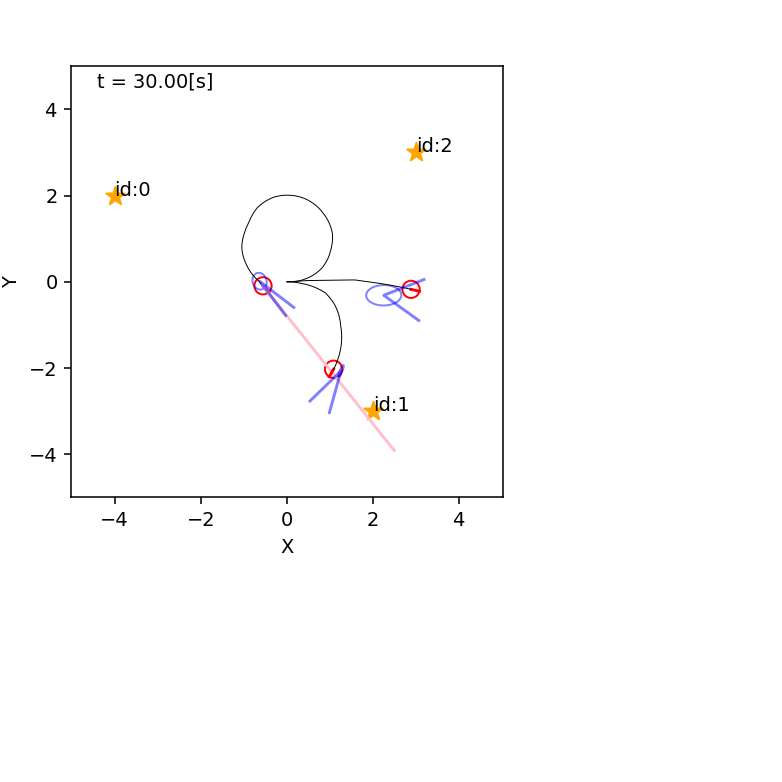

In [25]:
#ワールドの作成，ロボットの作成は robot.py から

if __name__ == '__main__': 
    
    # シミュレーションの周期 0.1秒毎
    time_interval = 0.1
    # 30秒worldを更新 300回描写
    world = World(30, time_interval, debug=False) 

    ### 地図を生成して3つランドマークを追加 ###
    m = Map()                                  
    m.append_landmark(Landmark(-4,2))
    m.append_landmark(Landmark(2,-3))
    m.append_landmark(Landmark(3,3))
    world.append(m)          

    ### ロボットを作る ###
    # ロボットの初期位置
    initial_pose = np.array([0, 0, 0]).T
    # 1台目（旋回する）
    kf = KalmanFilter(m, initial_pose)
    # カルマンフィルタを実行し，時刻tの信念を平均値と共分散行列で表現
    # 並進速度0.2 回転=10.0[deg/s]/180*PI=0.175[rad/s],初期位置
    circling = KfAgent(time_interval, 0.2, 10.0/180*math.pi, kf)
    # ロボットに反映
    r = Robot(initial_pose, sensor=Camera(m), agent=circling, color="red")
    world.append(r)
    
    # 1台目と同じ方法で，移動する方向のみを変えて残り2台実行する．
    
    # 2台目（右にまっすぐ）
    kf = KalmanFilter(m, initial_pose)
    # 並進0.1 回転０ 進行方向に直進　初期位置
    linear = KfAgent(time_interval, 0.1, 0.0, kf)
    # ロボットに反映
    r = Robot(initial_pose, sensor=Camera(m), agent=linear, color="red")
    world.append(r)
    
    # 3台目（右旋回）
    kf = KalmanFilter(m, initial_pose)
    # １代目のロボットと同様
    right = KfAgent(time_interval, 0.1, -3.0/180*math.pi, kf)
    # ロボットに反映
    r = Robot(initial_pose, sensor=Camera(m), agent=right, color="red")
    world.append(r)

    world.draw()